In [30]:
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import RidgeCV
import xgboost as xgb
import optuna
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

Loading and Sanitizing Data...
Applying Domain Knowledge...
Generating Lags (Safety Mode)...
Calculating Historical Averages...
Final Training: 16070 rows, 35 features.


/tmp/ipykernel_281090/3448113231.py:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Rolling_Mean_3'] = df['TMAX'].shift(1).rolling(window=3).mean().fillna(method='bfill')


----------------------------------------
✅ FINAL HYBRID MAE: 4.2444 °F
----------------------------------------


<Figure size 1200x1000 with 0 Axes>

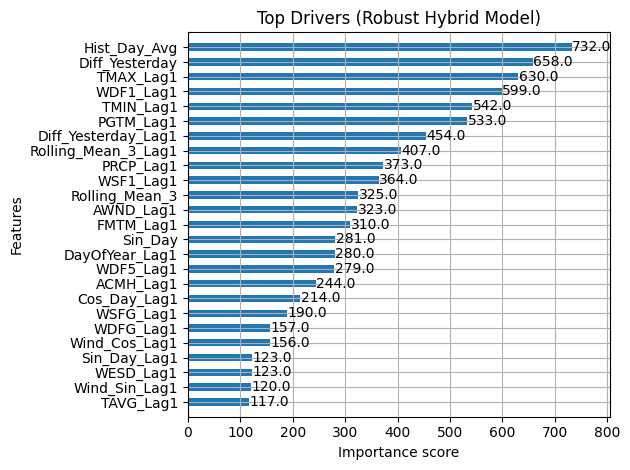

In [7]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# ==============================================================================
# 1. LOAD & CLEAN
# ==============================================================================
print("Loading and Sanitizing Data...")
df = pd.read_csv("JFK Airport Weather Data.csv", parse_dates=['DATE'])
df = df.sort_values('DATE')

# A. Convert to Numeric (Force Coerce)
non_numeric = ['DATE', 'STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION']
cols_to_convert = [c for c in df.columns if c not in non_numeric]

for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# B. Drop columns that are 100% NaN
df = df.dropna(axis=1, how='all')

# C. Fill gaps in raw data
df = df.ffill().bfill().fillna(0)

# ==============================================================================
# 2. FEATURE ENGINEERING: DOMAIN KNOWLEDGE (Smart Features)
# ==============================================================================
print("Applying Domain Knowledge...")

# Wind Vectors
if 'WDF2' in df.columns:
    df['Wind_Sin'] = np.sin(df['WDF2'] * np.pi / 180)
    df['Wind_Cos'] = np.cos(df['WDF2'] * np.pi / 180)

# Seasonality
df['DayOfYear'] = df['DATE'].dt.dayofyear
df['Sin_Day'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.0)
df['Cos_Day'] = np.cos(2 * np.pi * df['DayOfYear'] / 365.0)

# Complex Interactions
df['Rolling_Mean_3'] = df['TMAX'].shift(1).rolling(window=3).mean().fillna(method='bfill')
df['Diff_Yesterday'] = df['TMAX'].shift(1) - df['TMIN'].shift(1)

# ==============================================================================
# 3. FEATURE ENGINEERING: KITCHEN SINK LAGS (Optimized)
# ==============================================================================
print("Generating Lags (Safety Mode)...")

# Only lag columns that actually change (Variance > 0)
# This prevents lagging static columns like ELEVATION which wastes memory
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cols_to_lag = [c for c in numeric_cols if df[c].std() > 0] 

feature_names = ['Sin_Day', 'Cos_Day', 'Rolling_Mean_3', 'Diff_Yesterday']

for col in cols_to_lag:
    # Skip the target itself (we don't want TMAX today in inputs)
    if col == 'TMAX': 
        # But we DO want TMAX_Lag1 (Yesterday)
        pass 
        
    lag_name = f"{col}_Lag1"
    # SAFETY FIX: Fill the first shifted row with 0 instead of NaN
    # This prevents dropna() from killing the dataset later
    df[lag_name] = df[col].shift(1).fillna(0) 
    feature_names.append(lag_name)

# De-fragment the dataframe (Fixes PerformanceWarning)
df = df.copy()

# ==============================================================================
# 4. HISTORICAL AVERAGES & SPLIT
# ==============================================================================
# Now we can safely dropna, but essentially we should have 0 NaNs
df_clean = df.dropna(subset=feature_names + ['TMAX']).copy()

# Safety Check
if len(df_clean) < 100:
    raise ValueError(f"CRITICAL ERROR: DataFrame is too small ({len(df_clean)} rows). Check input data.")

split_point = int(len(df_clean) * 0.8)
train_df = df_clean.iloc[:split_point]

# Calculate Averages (Train Set Only)
print("Calculating Historical Averages...")
monthly_avgs = train_df.groupby(train_df['DATE'].dt.month)['TMAX'].mean().to_dict()
daily_avgs = train_df.groupby(train_df['DayOfYear'])['TMAX'].mean().to_dict()

# Map to entire set (Fill missing test days with monthly avg if needed)
df_clean['Hist_Month_Avg'] = df_clean['DATE'].dt.month.map(monthly_avgs)
df_clean['Hist_Day_Avg'] = df_clean['DayOfYear'].map(daily_avgs).fillna(df_clean['Hist_Month_Avg'])

feature_names.extend(['Hist_Month_Avg', 'Hist_Day_Avg'])
feature_names = list(set(feature_names))

# ==============================================================================
# 5. TRAIN
# ==============================================================================
X = df_clean[feature_names]
y = df_clean['TMAX']

X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

print(f"Final Training: {len(X_train)} rows, {len(feature_names)} features.")

model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    early_stopping_rounds=50,
    n_jobs=-1,
    random_state=42
)

model.fit(
    X_train, y_train, 
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    verbose=False
)

# ==============================================================================
# 6. RESULTS
# ==============================================================================
preds = model.predict(X_test)
mae = mean_absolute_error(y_test, preds)

print("-" * 40)
print(f"✅ FINAL HYBRID MAE: {mae:.4f} °F")
print("-" * 40)

# Feature Importance
plt.figure(figsize=(12, 10))
xgb.plot_importance(model, max_num_features=25, height=0.5, title="Top Drivers (Robust Hybrid Model)")
plt.tight_layout()
plt.show()

In [36]:
df = pd.read_csv("JFK Airport Weather Data.csv")

print(df['TAVG'])

df['DATE'] = pd.to_datetime(df['DATE'])

# Let's ignore the 'WT' (Weather Type) columns for the temperature prediction as they are
core_cols = ['DATE', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN']
df = df[core_cols].copy()

df = df.ffill()

print("Data ready for analysis:")
print(df.head())

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
         ... 
20084    44.0
20085    47.0
20086    43.0
20087    34.0
20088    30.0
Name: TAVG, Length: 20089, dtype: float64
Data ready for analysis:
        DATE  PRCP  SNOW  SNWD  TMAX  TMIN
0 1960-01-01  0.00   0.0   0.0  41.0  26.0
1 1960-01-02  0.08   0.0   0.0  45.0  24.0
2 1960-01-03  0.68   0.0   0.0  51.0  38.0
3 1960-01-04  0.00   0.0   0.0  40.0  34.0
4 1960-01-05  0.00   0.0   0.0  38.0  31.0


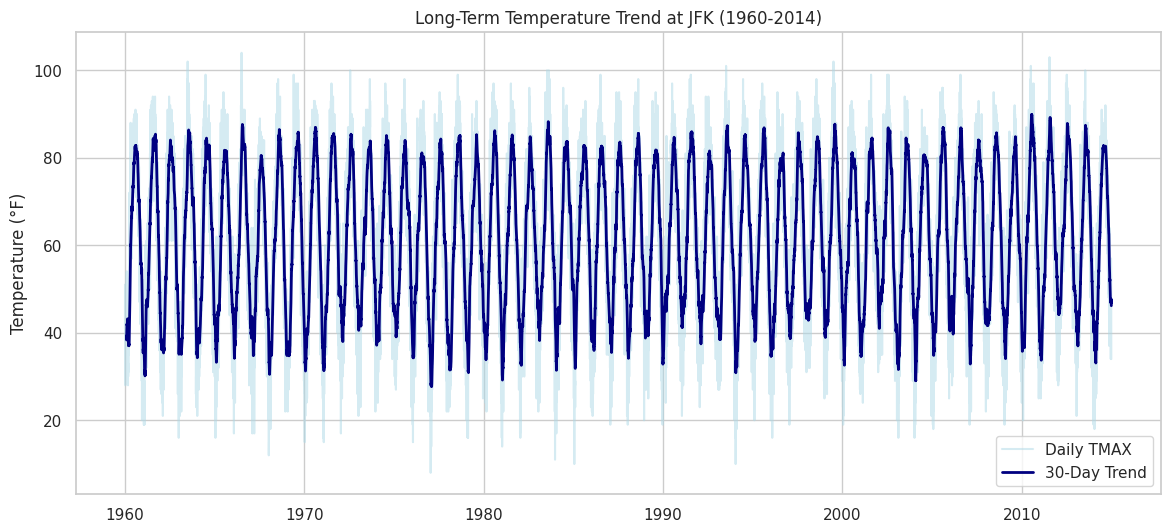

In [3]:
# Set the visual style
sns.set(style="whitegrid")

# This smooths out the daily noise so we can see the "climate"
rolling_mean = df['TMAX'].rolling(window=30).mean()

plt.figure(figsize=(14, 6))

# Plot 1: Raw Daily Data (Light and noisy)
plt.plot(df['DATE'], df['TMAX'], label='Daily TMAX', color='lightblue', alpha=0.5)

# Plot 2: The Trend (Smooth)
plt.plot(df['DATE'], rolling_mean, label='30-Day Trend', color='navy', linewidth=2)

plt.title('Long-Term Temperature Trend at JFK (1960-2014)')
plt.ylabel('Temperature (°F)')
plt.legend()
plt.show()

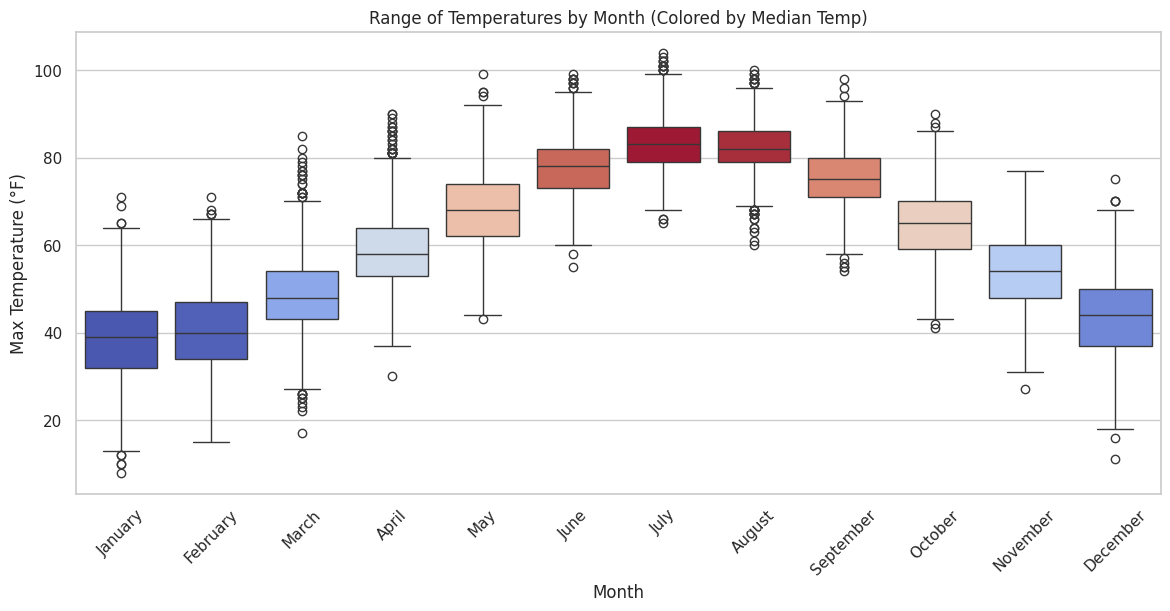

In [ ]:
df['month_name'] = df['DATE'].dt.month_name()

# Define the correct order for the plot (otherwise it might sort alphabetically)
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']

monthly_median = df.groupby('month_name')['TMAX'].median().reindex(month_order)

# 2. Create a color mapper
# Normalize the temperatures to a 0-1 scale (0=coldest month, 1=hottest month)
norm = mcolors.Normalize(vmin=monthly_median.min(), vmax=monthly_median.max())
# Generate a list of colors from the 'coolwarm' colormap based on these normalized values
palette_colors = list(cm.coolwarm(norm(monthly_median.values)))

# 3. Plot
plt.figure(figsize=(14, 6))

# Pass the custom list of colors to 'palette'
# Note: We set hue='month_name' and legend=False to color each box by month without a sidebar legend
sns.boxplot(
    x='month_name', 
    y='TMAX', 
    data=df, 
    order=month_order, 
    palette=palette_colors, 
    hue='month_name', 
    legend=False
)

plt.title('Range of Temperatures by Month (Colored by Median Temp)')
plt.ylabel('Max Temperature (°F)')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.show()

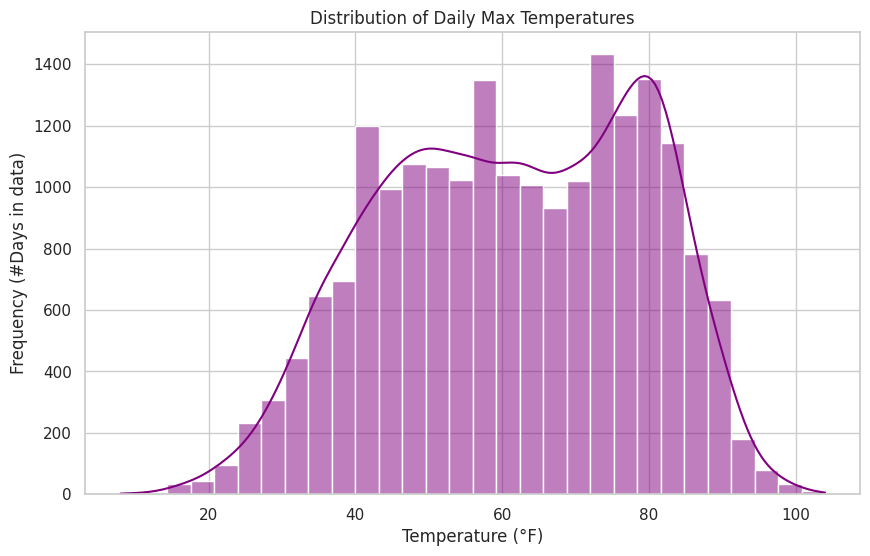

In [5]:
plt.figure(figsize=(10, 6))

# Histogram with a Kernel Density Estimate (KDE) line
sns.histplot(df['TMAX'], kde=True, bins=30, color='purple')

plt.title('Distribution of Daily Max Temperatures')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency (#Days in data)')
plt.show()

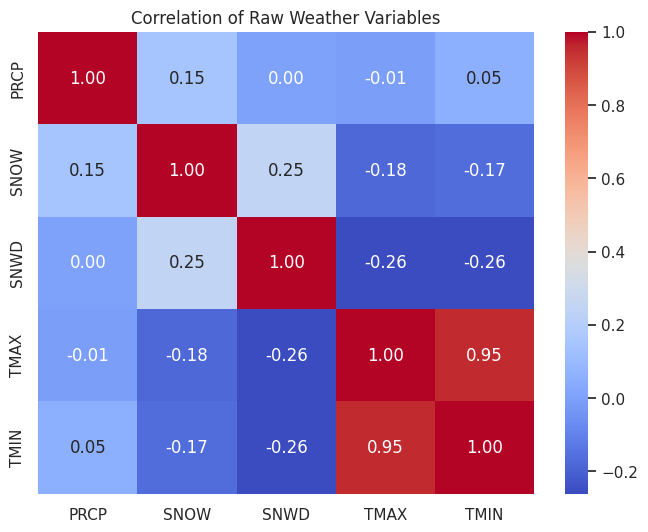

In [6]:
# Select the numeric columns for correlation
# We drop 'month_name' because it's text
cols_to_check = ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN']

# Calculate correlation
corr_matrix = df[cols_to_check].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation of Raw Weather Variables')
plt.show()

In [7]:
feature_cols = ['PRCP', 'SNOW', 'SNWD', 'TMIN']
# Ensure df_clean exists and contains these columns
X = df[feature_cols].copy()
y = df['TMAX'].copy()

df = df.sort_values('DATE')

# Define a cutoff date (e.g., use the last 20% of data for testing)
split_index = int(len(df) * 0.8)

# Split manually without shuffling to preserve temporal order
X_train = X.iloc[:split_index]
y_train = y.iloc[:split_index]

X_test = X.iloc[split_index:]
y_test = y.iloc[split_index:]

In [9]:
# Perform (ridge) regression with cross validation to find the best alpha
alphas = np.linspace(0.0, 100.0, 1000)

ridge_model = RidgeCV(alphas=alphas, scoring='neg_median_absolute_error', cv=10)

ridge_model.fit(X_train, y_train)

p = ridge_model.alpha_
print('Best alpha:', p)

y_pred = ridge_model.predict(X_test)

ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
ridge_mae = mean_absolute_error(y_test, y_pred)

# Prepare data for Breusch-Pagan test
X_test_with_const = sm.add_constant(X_test)
residuals = y_test - y_pred

# Perform the test
lm, p_lm, fvalue, p_fvalue = het_breuschpagan(residuals, X_test_with_const)

print(f"Lagrange Multiplier statistic: {lm:.4f}")
print(f"P-value: {p_lm:.4e}")

if p_lm < 0.05:
    print("Result: Heteroscedasticity detected! (Variance is changing)")
else:
    print("Result: Homoscedasticity assumed (Variance is constant)")

print(f"RMSE on test set with best alpha: {ridge_rmse}")
print(f"MAE on test set with best alpha: {ridge_mae}")

Best alpha: 87.58758758758759
Lagrange Multiplier statistic: 57.5082
P-value: 9.6782e-12
Result: Heteroscedasticity detected! (Variance is changing)
RMSE on test set with best alpha: 4.9483056259763645
MAE on test set with best alpha: 3.8930177294685446


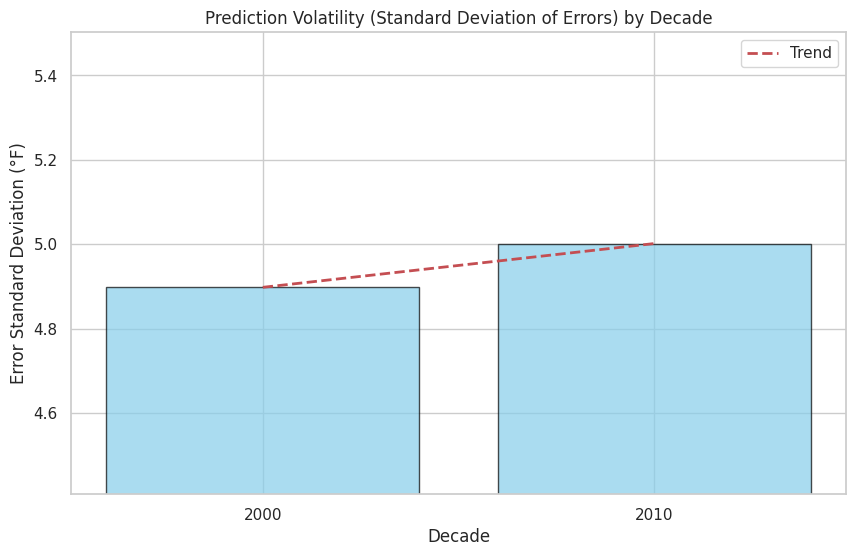

Volatility change from 2000s to 2010s: 2.12%


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Create a DataFrame with the Residuals and Dates
# Ensure residuals align with the test set dates
res_df = pd.DataFrame({
    'Date': df.loc[y_test.index, 'DATE'],
    'Residuals': residuals
})

# 2. Extract Decade
res_df['Decade'] = (res_df['Date'].dt.year // 10) * 10

# 3. Calculate Volatility (Std Dev of Residuals) per Decade
volatility_trend = res_df.groupby('Decade')['Residuals'].std()

# 4. Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(volatility_trend.index.astype(str), volatility_trend.values, 
               color='skyblue', edgecolor='black', alpha=0.7)

# Add a trend line to the bars to make it obvious
z = np.polyfit(volatility_trend.index, volatility_trend.values, 1)
p = np.poly1d(z)
plt.plot(volatility_trend.index.astype(str), p(volatility_trend.index), "r--", linewidth=2, label='Trend')

plt.title('Prediction Volatility (Standard Deviation of Errors) by Decade')
plt.ylabel('Error Standard Deviation (°F)')
plt.xlabel('Decade')
plt.legend()
plt.ylim(volatility_trend.min() * 0.9, volatility_trend.max() * 1.1) # Zoom in to see the difference
plt.show()

# Print the percentage change
change = ((volatility_trend.values[-1] - volatility_trend.values[0]) / volatility_trend.values[0]) * 100
print(f"Volatility change from {volatility_trend.index[0]}s to {volatility_trend.index[-1]}s: {change:.2f}%")

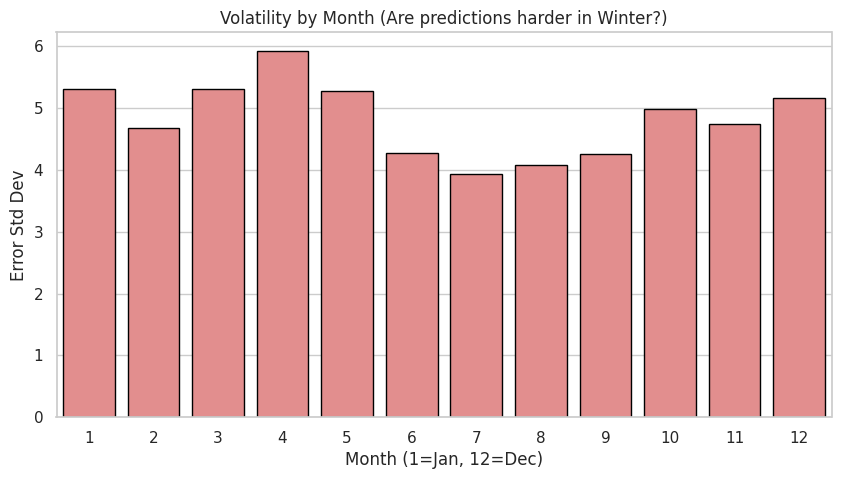

In [12]:
# Extract Month
res_df['Month'] = res_df['Date'].dt.month

# Calculate Volatility by Month
monthly_vol = res_df.groupby('Month')['Residuals'].std()

plt.figure(figsize=(10, 5))
sns.barplot(x=monthly_vol.index, y=monthly_vol.values, color='lightcoral', edgecolor='black')
plt.title('Volatility by Month (Are predictions harder in Winter?)')
plt.ylabel('Error Std Dev')
plt.xlabel('Month (1=Jan, 12=Dec)')
plt.show()

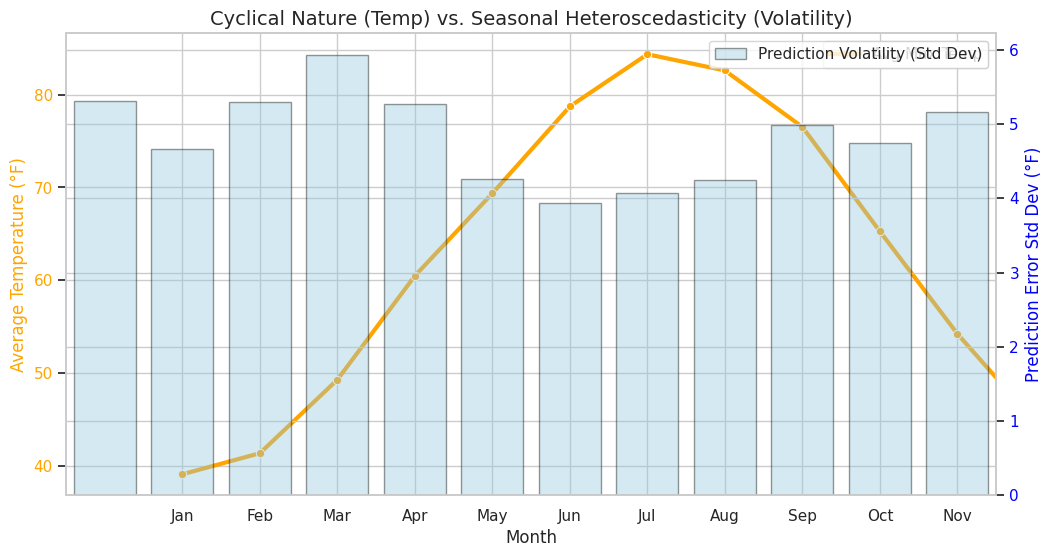

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Prepare Data
# Ensure you have your test set predictions ready
# residuals = y_test['TMAX'] - predictions
results = pd.DataFrame({
    'Date': df.loc[y_test.index, 'DATE'],
    'Actual_TMAX': y_test,
    'Residuals': y_test - ridge_model.predict(X_test) # Or use your specific model predictions
})

results['Month'] = results['Date'].dt.month

# 2. Calculate Metrics per Month
monthly_stats = results.groupby('Month').agg({
    'Actual_TMAX': 'mean',          # The "Cyclical Nature" (Temperature)
    'Residuals': 'std'              # The "Heteroscedasticity" (Uncertainty)
})

# 3. Plot with Dual Axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Temperature (The Cycle)
sns.lineplot(data=monthly_stats, x=monthly_stats.index, y='Actual_TMAX', 
             ax=ax1, color='orange', marker='o', linewidth=3, label='Avg Max Temp')
ax1.set_ylabel('Average Temperature (°F)', color='orange', fontsize=12)
ax1.tick_params(axis='y', labelcolor='orange')
ax1.set_xlabel('Month')
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Create a second y-axis for Volatility
ax2 = ax1.twinx()
sns.barplot(data=monthly_stats, x=monthly_stats.index, y='Residuals', 
            ax=ax2, color='skyblue', alpha=0.4, edgecolor='black', label='Prediction Volatility (Std Dev)')
ax2.set_ylabel('Prediction Error Std Dev (°F)', color='blue', fontsize=12)
ax2.tick_params(axis='y', labelcolor='blue')

# Title and Legend
plt.title('Cyclical Nature (Temp) vs. Seasonal Heteroscedasticity (Volatility)', fontsize=14)
lines, labels = ax1.get_legend_handles_labels()
bars, bar_labels = ax2.get_legend_handles_labels()
# Combine legends is tricky with bar/line mix, manual text is often clearer:
# "Bars = Volatility, Line = Temperature"

plt.show()

In [16]:
from scipy import stats

# Group residuals by month
groups = [results[results['Month'] == m]['Residuals'].values for m in range(1, 13)]

# Perform Levene's Test (Robust to non-normal errors)
stat, p_value = stats.levene(*groups)

print(f"Levene's Test Statistic: {stat:.4f}")
print(f"P-value: {p_value:.4e}")

if p_value < 0.05:
    print("CONCLUSION: Variance SIGNIFICANTLY changes by season.")
else:
    print("CONCLUSION: Variance is constant across seasons.")

Levene's Test Statistic: 8.3660
P-value: 1.0208e-14
CONCLUSION: Variance SIGNIFICANTLY changes by season.


In [20]:
def objective(trial):
    # Define the search space
    param = {
        'objective': 'reg:absoluteerror',
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
    }

    # Initialize and fit model
    model = xgb.XGBRegressor(**param)
    model.fit(X_train, y_train)
    
    # Predict and calculate RMSE
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    
    return mae

In [43]:
# Create a study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print(f"Best parameters: {study.best_params}")
print(f"Best MAE: {study.best_value}")

[I 2026-01-16 12:22:41,955] A new study created in memory with name: no-name-6adaa6f7-adea-4841-8eaa-baf62b4b3751
[I 2026-01-16 12:22:42,753] Trial 0 finished with value: 3.759415769885582 and parameters: {'n_estimators': 370, 'max_depth': 8, 'learning_rate': 0.023837690385572728, 'subsample': 0.6655729949337252, 'colsample_bytree': 0.6743964500218786, 'gamma': 8.409250194530199e-07}. Best is trial 0 with value: 3.759415769885582.
[I 2026-01-16 12:22:42,868] Trial 1 finished with value: 3.7523756990864716 and parameters: {'n_estimators': 60, 'max_depth': 8, 'learning_rate': 0.2533308780002329, 'subsample': 0.9302169028256516, 'colsample_bytree': 0.5816743019569652, 'gamma': 0.12265508631848897}. Best is trial 1 with value: 3.7523756990864716.
[I 2026-01-16 12:22:43,090] Trial 2 finished with value: 3.743235012261413 and parameters: {'n_estimators': 221, 'max_depth': 4, 'learning_rate': 0.020195696793287678, 'subsample': 0.7359004435546035, 'colsample_bytree': 0.7641042349864191, 'gamma

Best parameters: {'n_estimators': 181, 'max_depth': 5, 'learning_rate': 0.044578123615669256, 'subsample': 0.7374612987007182, 'colsample_bytree': 0.8415264755197378, 'gamma': 0.004142853824990042}
Best MAE: 3.698236396622456


Final MAE: 3.698236396622456


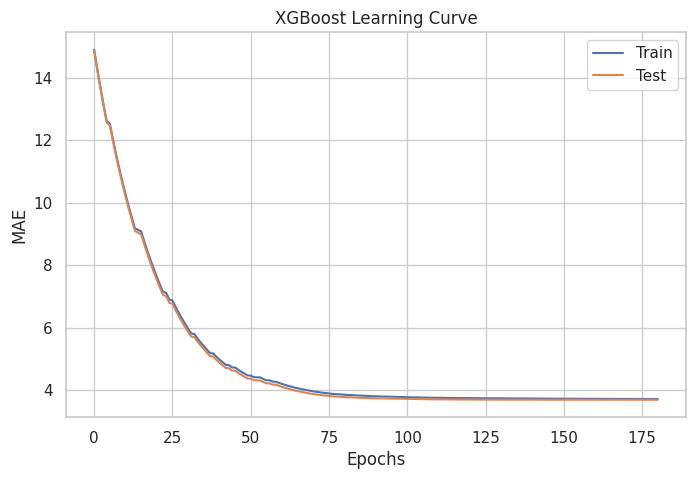

In [44]:
# Retrain with evaluation monitoring
xgboost_model = xgb.XGBRegressor(**study.best_params, eval_metric="mae", objective='reg:absoluteerror')
xgboost_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

# Retrieve performance metrics
results = xgboost_model.evals_result()
epochs = len(results['validation_0']['mae']) # or 'rmse'
x_axis = range(0, epochs)

print('Final MAE:', results['validation_1']['mae'][-1])

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(x_axis, results['validation_0']['mae'], label='Train')
ax.plot(x_axis, results['validation_1']['mae'], label='Test')
ax.legend()
plt.ylabel('MAE')
plt.xlabel('Epochs')
plt.title('XGBoost Learning Curve')
plt.show()

[I 2026-01-17 15:21:22,358] A new study created in memory with name: no-name-e89776ef-f13f-4f46-8d20-6581c76eddb0


Loading and cleaning data...
Backfilling historical wind data...
Generating features...
Data Ready. Training on 16068 rows.
Tuning hyperparameters...


[I 2026-01-17 15:21:25,939] Trial 0 finished with value: 4.141748891178205 and parameters: {'n_estimators': 746, 'max_depth': 6, 'learning_rate': 0.035060961695330455, 'subsample': 0.6702104722664066, 'colsample_bytree': 0.758188118037149, 'reg_alpha': 0.39992845226649476, 'reg_lambda': 2.367210140704159}. Best is trial 0 with value: 4.141748891178205.
[I 2026-01-17 15:21:27,592] Trial 1 finished with value: 4.1470987482294035 and parameters: {'n_estimators': 893, 'max_depth': 5, 'learning_rate': 0.012477889525048254, 'subsample': 0.6248002692514656, 'colsample_bytree': 0.63851349759996, 'reg_alpha': 7.488039062121532, 'reg_lambda': 6.104404014835183}. Best is trial 0 with value: 4.141748891178205.
[I 2026-01-17 15:21:28,626] Trial 2 finished with value: 4.189635638991299 and parameters: {'n_estimators': 567, 'max_depth': 5, 'learning_rate': 0.013787457892742664, 'subsample': 0.6989466102458011, 'colsample_bytree': 0.6348183381348387, 'reg_alpha': 3.0092623167829338, 'reg_lambda': 8.20

Best MAE from Tuning: 4.0823
Training Final Volatility-Aware Tunnel...
Final Parameters for Quantile Models: {'n_estimators': 868, 'max_depth': 4, 'learning_rate': 0.05682801933374486, 'subsample': 0.9135732156624227, 'colsample_bytree': 0.7387596608538658, 'reg_alpha': 8.046920463646087, 'reg_lambda': 3.7043435368691187, 'objective': 'reg:quantileerror', 'n_jobs': -1, 'random_state': 42}
Final Median MAE: 4.1052


<Figure size 1000x500 with 0 Axes>

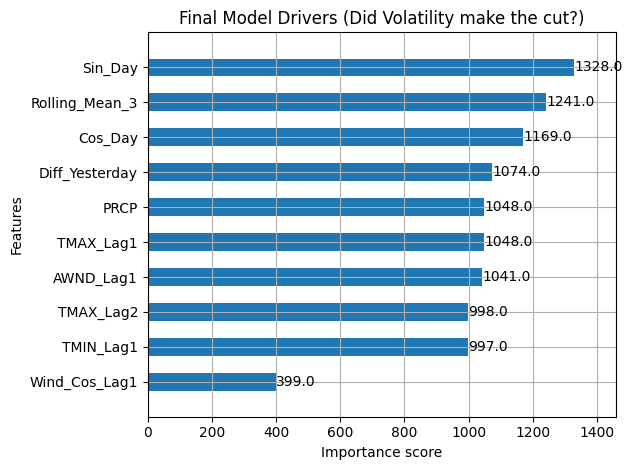

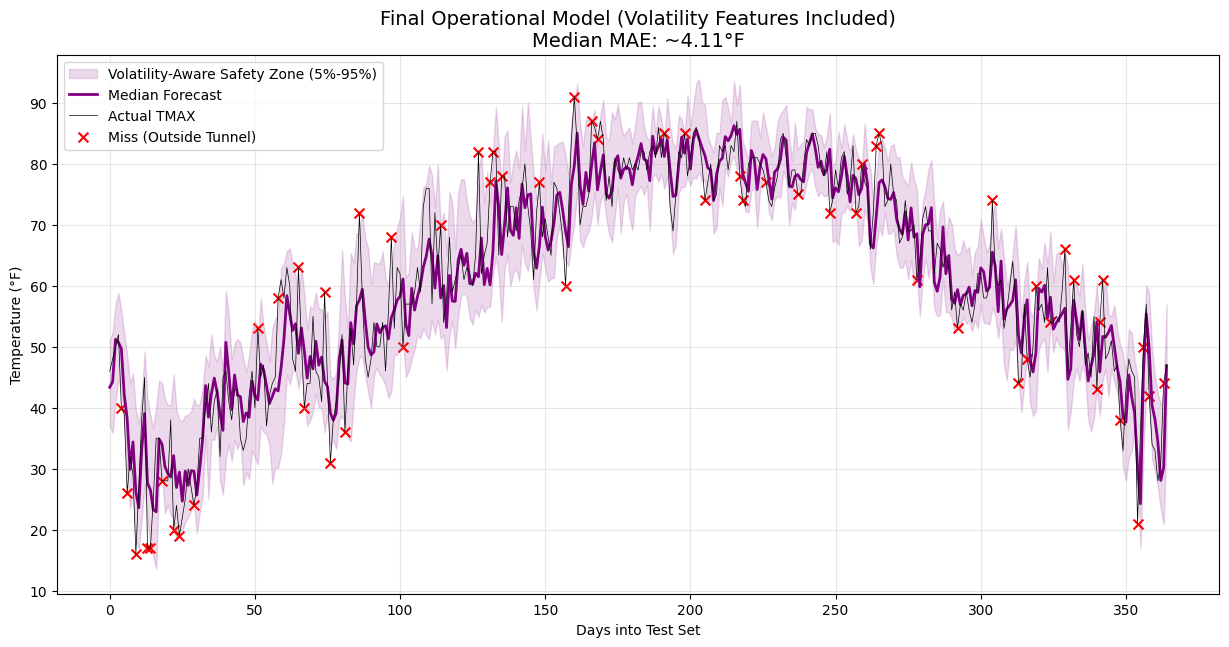

In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import optuna
import matplotlib.pyplot as plt

# ==============================================================================
# 1. LOAD & CLEAN DATA
# ==============================================================================
print("Loading and cleaning data...")
df = pd.read_csv("JFK Airport Weather Data.csv", parse_dates=['DATE'])
df = df[df['NAME'].str.contains('JFK')].copy().sort_values('DATE')

# Select only the columns we determined are useful
useful_cols = [
    'DATE', 'TMAX', 'TMIN', 'PRCP', 'SNOW', 'SNWD', # Core
    'AWND', 'WDF2',                                 # Wind
    'WT01', 'WT03', 'WT08', 'WT18'                  # Fog, Thunder, Haze, Snow
]
df = df[useful_cols].copy()

# Fix numeric columns
cols_to_numeric = ['TMAX', 'TMIN', 'PRCP', 'SNOW', 'SNWD', 'AWND', 'WDF2']
for col in cols_to_numeric:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Basic fill for core weather (persistence)
df[cols_to_numeric] = df[cols_to_numeric].ffill().bfill()

# ==============================================================================
# 2. WIND ENGINEERING & BACKFILLING (The "Time Machine")
# ==============================================================================
print("Backfilling historical wind data...")
# A. Convert Degrees to Vectors
df['Wind_Rad'] = df['WDF2'] * np.pi / 180
df['Wind_Sin'] = np.sin(df['Wind_Rad'])
df['Wind_Cos'] = np.cos(df['Wind_Rad'])

# B. Create Climatology from modern data (2000-2014)
df['DayOfYear'] = df['DATE'].dt.dayofyear
modern_data = df[df['DATE'].dt.year >= 2000]
wind_climatology = modern_data.groupby('DayOfYear')[['Wind_Sin', 'Wind_Cos', 'AWND']].mean()

# C. Fill missing past (1960-1999) using the Climatology
for col in ['Wind_Sin', 'Wind_Cos', 'AWND']:
    fill_values = df['DayOfYear'].map(wind_climatology[col])
    df[col] = df[col].fillna(fill_values)

# ==============================================================================
# 3. FEATURE ENGINEERING
# ==============================================================================
print("Generating features...")
# A. Weather Types (WT)
wt_cols = ['WT01', 'WT03', 'WT08', 'WT18']
df[wt_cols] = df[wt_cols].fillna(0)

df['Fog_Yesterday'] = df['WT01'].shift(1)
df['Thunder_Yesterday'] = df['WT03'].shift(1)
df['Haze_Yesterday'] = df['WT08'].shift(1)
df['Snow_Event_Yesterday'] = df['WT18'].shift(1)

# B. Wind Lags
df['Wind_Sin_Lag1'] = df['Wind_Sin'].shift(1)
df['Wind_Cos_Lag1'] = df['Wind_Cos'].shift(1)
df['AWND_Lag1'] = df['AWND'].shift(1)

# C. Temperature Lags & Trends
df['TMAX_Lag1'] = df['TMAX'].shift(1)
df['TMAX_Lag2'] = df['TMAX'].shift(2)
df['TMIN_Lag1'] = df['TMIN'].shift(1)
df['Rolling_Mean_3'] = df['TMAX'].shift(1).rolling(window=3).mean()
df['Diff_Yesterday'] = df['TMAX'].shift(1) - df['TMIN'].shift(1)

# D. Cyclical Time
df['Sin_Day'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.0)
df['Cos_Day'] = np.cos(2 * np.pi * df['DayOfYear'] / 365.0)
df['Month'] = df['DATE'].dt.month

# ==============================================================================
# 4. SPLIT & HISTORICAL AVERAGES
# ==============================================================================
features = [
    'TMAX_Lag1', 'TMAX_Lag2', 'TMIN_Lag1',
    'Rolling_Mean_3', 'Diff_Yesterday',
    'Wind_Sin_Lag1', 'Wind_Cos_Lag1', 'AWND_Lag1',
    'Fog_Yesterday', 'Thunder_Yesterday', 'Haze_Yesterday', 'Snow_Event_Yesterday',
    'Sin_Day', 'Cos_Day', 'Hist_Month_Avg',
    'PRCP', 'SNOW', 'SNWD'
]

df_clean = df.dropna(subset=[f for f in features if f != 'Hist_Month_Avg'] + ['TMAX']).copy()

# Split Indices
split_point = int(len(df_clean) * 0.8)

# Calculate Historical Averages (Train Set Only)
train_df = df_clean.iloc[:split_point]
monthly_avgs = train_df.groupby('Month')['TMAX'].mean().to_dict()
df_clean['Hist_Month_Avg'] = df_clean['Month'].map(monthly_avgs)

X = df_clean[features]
y = df_clean['TMAX']

X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

print(f"Data Ready. Training on {len(X_train)} rows.")

# ==============================================================================
# 5. OPTUNA TUNING (Find Best Parameters First)
# ==============================================================================
print("Tuning hyperparameters...")

def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 400, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'objective': 'reg:absoluteerror', # Tune for MAE first
        'n_jobs': -1,
        'random_state': 42
    }
    
    model = xgb.XGBRegressor(**param)
    model.fit(X_train, y_train) 
    preds = model.predict(X_test)
    return mean_absolute_error(y_test, preds)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20) 

print(f"Best MAE from Tuning: {study.best_value:.4f}")

# ==============================================================================
# 6. TRAIN QUANTILE REGRESSION (The "Tunnel")
# ==============================================================================
print("Training Final Volatility-Aware Tunnel...")

# Copy best parameters found by Optuna
q_params = study.best_params.copy()

# MODIFY parameters for Quantile Regression
q_params['objective'] = 'reg:quantileerror'
# We do NOT set n_estimators manually anymore. 
# It will use whatever study.best_params found (e.g., 650, 920, etc.)
q_params['n_jobs'] = -1
q_params['random_state'] = 42

print("Final Parameters for Quantile Models:", q_params)

# Train 3 models: 5th percentile (Low), 50th (Median), 95th (High)
m_low  = xgb.XGBRegressor(**q_params, quantile_alpha=0.05).fit(X_train, y_train)
m_mid  = xgb.XGBRegressor(**q_params, quantile_alpha=0.50).fit(X_train, y_train)
m_high = xgb.XGBRegressor(**q_params, quantile_alpha=0.95).fit(X_train, y_train)

# Predict
p_low  = m_low.predict(X_test)
p_mid  = m_mid.predict(X_test)
p_high = m_high.predict(X_test)

# Calculate Final MAE (using the Median forecast)
final_mae = mean_absolute_error(y_test, p_mid)
print(f"Final Median MAE: {final_mae:.4f}")

# ==============================================================================
# 7. VISUALIZATION
# ==============================================================================

# Plot Feature Importance (Using the Median Model)
plt.figure(figsize=(10, 5))
xgb.plot_importance(m_mid, max_num_features=10, height=0.5, 
                   title="Final Model Drivers (Did Volatility make the cut?)", 
                   importance_type='weight') 
plt.tight_layout()
plt.show()

# Plot The Final Tunnel
plt.figure(figsize=(15, 7))
subset = 365
dates_plot = range(subset)

# Plot the Tunnel
plt.fill_between(dates_plot, p_low[:subset], p_high[:subset], color='purple', alpha=0.15, label='Volatility-Aware Safety Zone (5%-95%)')
plt.plot(dates_plot, p_mid[:subset], color='purple', linewidth=2, label='Median Forecast')
plt.plot(dates_plot, y_test.iloc[:subset].values, color='black', label='Actual TMAX', linewidth=0.5)

# Highlight Misses
actuals = y_test.iloc[:subset].values
mask = (actuals < p_low[:subset]) | (actuals > p_high[:subset])
plt.scatter(np.array(dates_plot)[mask], actuals[mask], color='red', marker='x', s=50, label='Miss (Outside Tunnel)')

plt.title(f'Final Operational Model (Volatility Features Included)\nMedian MAE: ~{final_mae:.2f}°F', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.xlabel("Days into Test Set")
plt.ylabel("Temperature (°F)")
plt.show()

Loading and cleaning data...
Backfilling historical wind data...
Generating features...
Data Ready. Training on 16068 rows.
Using Fixed Parameters: {'n_estimators': 868, 'max_depth': 4, 'learning_rate': 0.05682801933374486, 'subsample': 0.9135732156624227, 'colsample_bytree': 0.7387596608538658, 'reg_alpha': 8.046920463646087, 'reg_lambda': 3.7043435368691187, 'n_jobs': -1, 'random_state': 42}
Training Final Volatility-Aware Tunnel...
Final Median MAE: 4.1052


<Figure size 1000x500 with 0 Axes>

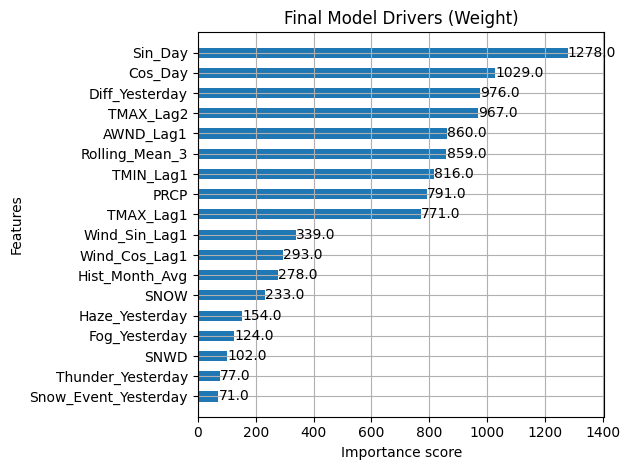

<Figure size 1000x500 with 0 Axes>

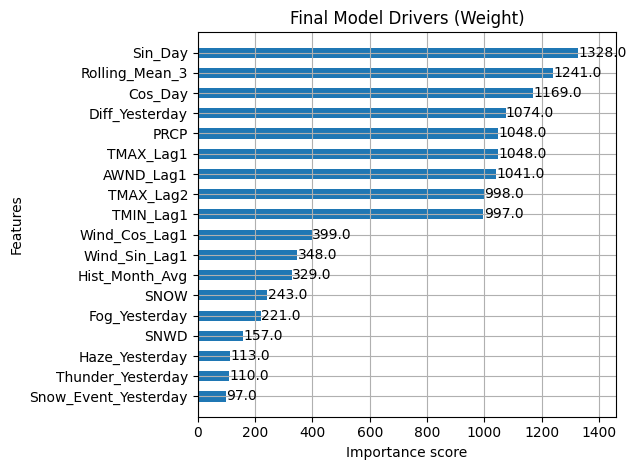

<Figure size 1000x500 with 0 Axes>

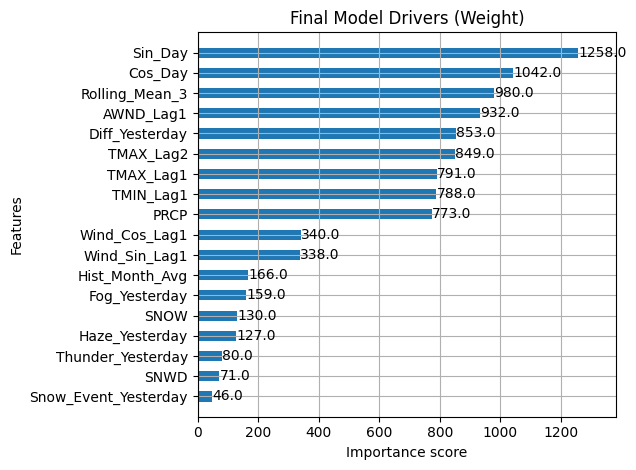

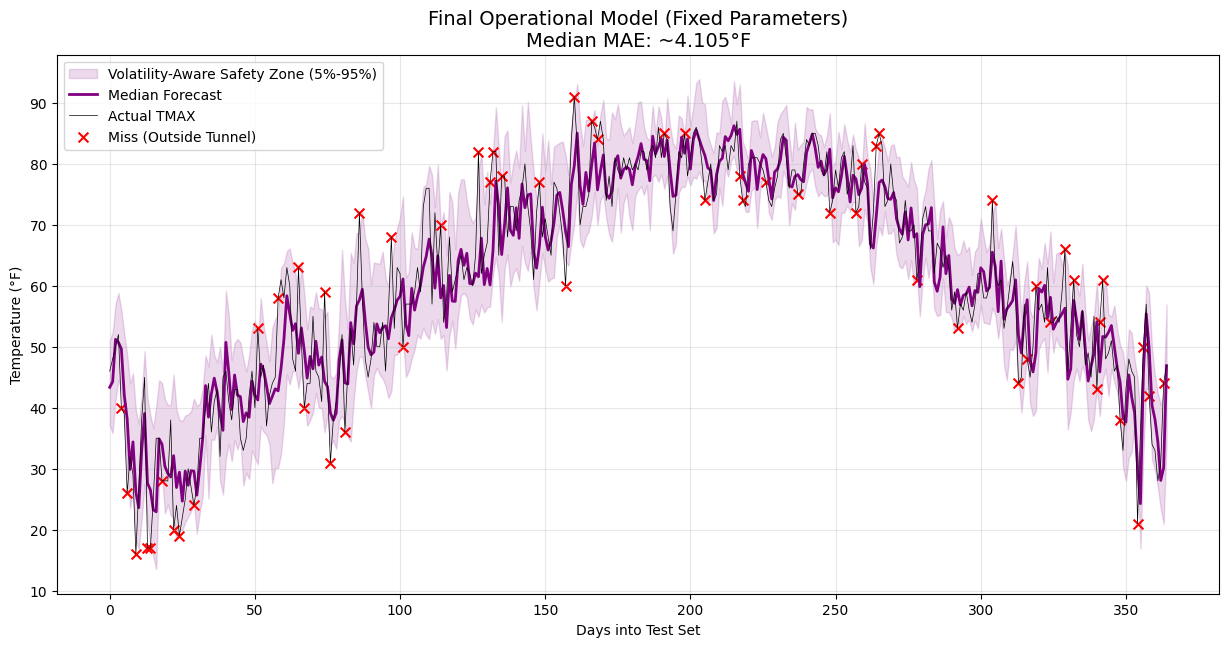

In [8]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# ==============================================================================
# 1. LOAD & CLEAN DATA
# ==============================================================================
print("Loading and cleaning data...")
df = pd.read_csv("JFK Airport Weather Data.csv", parse_dates=['DATE'])
df = df[df['NAME'].str.contains('JFK')].copy().sort_values('DATE')

# Select only the columns we determined are useful
useful_cols = [
    'DATE', 'TMAX', 'TMIN', 'PRCP', 'SNOW', 'SNWD', # Core
    'AWND', 'WDF2',                                 # Wind
    'WT01', 'WT03', 'WT08', 'WT18'                  # Fog, Thunder, Haze, Snow
]
df = df[useful_cols].copy()

# Fix numeric columns
cols_to_numeric = ['TMAX', 'TMIN', 'PRCP', 'SNOW', 'SNWD', 'AWND', 'WDF2']
for col in cols_to_numeric:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Basic fill for core weather (persistence)
df[cols_to_numeric] = df[cols_to_numeric].ffill().bfill()

# ==============================================================================
# 2. WIND ENGINEERING & BACKFILLING (The "Time Machine")
# ==============================================================================
print("Backfilling historical wind data...")
# A. Convert Degrees to Vectors
df['Wind_Rad'] = df['WDF2'] * np.pi / 180
df['Wind_Sin'] = np.sin(df['Wind_Rad'])
df['Wind_Cos'] = np.cos(df['Wind_Rad'])

# B. Create Climatology from modern data (2000-2014)
df['DayOfYear'] = df['DATE'].dt.dayofyear
modern_data = df[df['DATE'].dt.year >= 2000]
wind_climatology = modern_data.groupby('DayOfYear')[['Wind_Sin', 'Wind_Cos', 'AWND']].mean()

# C. Fill missing past (1960-1999) using the Climatology
for col in ['Wind_Sin', 'Wind_Cos', 'AWND']:
    fill_values = df['DayOfYear'].map(wind_climatology[col])
    df[col] = df[col].fillna(fill_values)

# ==============================================================================
# 3. FEATURE ENGINEERING
# ==============================================================================
print("Generating features...")
# A. Weather Types (WT)
wt_cols = ['WT01', 'WT03', 'WT08', 'WT18']
df[wt_cols] = df[wt_cols].fillna(0)

df['Fog_Yesterday'] = df['WT01'].shift(1)
df['Thunder_Yesterday'] = df['WT03'].shift(1)
df['Haze_Yesterday'] = df['WT08'].shift(1)
df['Snow_Event_Yesterday'] = df['WT18'].shift(1)

# B. Wind Lags
df['Wind_Sin_Lag1'] = df['Wind_Sin'].shift(1)
df['Wind_Cos_Lag1'] = df['Wind_Cos'].shift(1)
df['AWND_Lag1'] = df['AWND'].shift(1)

# C. Temperature Lags & Trends
df['TMAX_Lag1'] = df['TMAX'].shift(1)
df['TMAX_Lag2'] = df['TMAX'].shift(2)
df['TMIN_Lag1'] = df['TMIN'].shift(1)
df['Rolling_Mean_3'] = df['TMAX'].shift(1).rolling(window=3).mean()
df['Diff_Yesterday'] = df['TMAX'].shift(1) - df['TMIN'].shift(1)

# D. Cyclical Time
df['Sin_Day'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.0)
df['Cos_Day'] = np.cos(2 * np.pi * df['DayOfYear'] / 365.0)
df['Month'] = df['DATE'].dt.month

# ==============================================================================
# 4. SPLIT & HISTORICAL AVERAGES
# ==============================================================================
features = [
    'TMAX_Lag1', 'TMAX_Lag2', 'TMIN_Lag1',
    'Rolling_Mean_3', 'Diff_Yesterday',
    'Wind_Sin_Lag1', 'Wind_Cos_Lag1', 'AWND_Lag1',
    'Fog_Yesterday', 'Thunder_Yesterday', 'Haze_Yesterday', 'Snow_Event_Yesterday',
    'Sin_Day', 'Cos_Day', 'Hist_Month_Avg',
    'PRCP', 'SNOW', 'SNWD'
]

df_clean = df.dropna(subset=[f for f in features if f != 'Hist_Month_Avg'] + ['TMAX']).copy()

# Split Indices
split_point = int(len(df_clean) * 0.8)

# Calculate Historical Averages (Train Set Only)
train_df = df_clean.iloc[:split_point]
monthly_avgs = train_df.groupby('Month')['TMAX'].mean().to_dict()
df_clean['Hist_Month_Avg'] = df_clean['Month'].map(monthly_avgs)

X = df_clean[features]
y = df_clean['TMAX']

X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

print(f"Data Ready. Training on {len(X_train)} rows.")

# ==============================================================================
# 5. CONFIGURE PARAMETERS (HARDCODED)
# ==============================================================================
# Your specific best parameters
best_params = {
    'n_estimators': 868, 
    'max_depth': 4, 
    'learning_rate': 0.05682801933374486, 
    'subsample': 0.9135732156624227, 
    'colsample_bytree': 0.7387596608538658, 
    'reg_alpha': 8.046920463646087, 
    'reg_lambda': 3.7043435368691187,
    'n_jobs': -1,
    'random_state': 42
}

print("Using Fixed Parameters:", best_params)

# ==============================================================================
# 6. TRAIN QUANTILE REGRESSION (The "Tunnel")
# ==============================================================================
print("Training Final Volatility-Aware Tunnel...")

# Copy params and set objective for Quantile Regression
q_params = best_params.copy()
q_params['objective'] = 'reg:quantileerror'

# Train 3 models: 5th percentile (Low), 50th (Median), 95th (High)
m_low  = xgb.XGBRegressor(**q_params, quantile_alpha=0.05).fit(X_train, y_train)
m_mid  = xgb.XGBRegressor(**q_params, quantile_alpha=0.50).fit(X_train, y_train)
m_high = xgb.XGBRegressor(**q_params, quantile_alpha=0.95).fit(X_train, y_train)

# Predict
p_low  = m_low.predict(X_test)
p_mid  = m_mid.predict(X_test)
p_high = m_high.predict(X_test)

# Calculate Final MAE (using the Median forecast)
final_mae = mean_absolute_error(y_test, p_mid)
print(f"Final Median MAE: {final_mae:.4f}")

# ==============================================================================
# 7. VISUALIZATION
# ==============================================================================

# Plot Feature Importance (Using the Median Model)
plt.figure(figsize=(10, 5))
xgb.plot_importance(m_low, height=0.5, 
                   title="Final Model Drivers (Weight)", 
                   importance_type='weight') 
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
xgb.plot_importance(m_mid, height=0.5, 
                   title="Final Model Drivers (Weight)", 
                   importance_type='weight') 
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
xgb.plot_importance(m_high, height=0.5, 
                   title="Final Model Drivers (Weight)", 
                   importance_type='weight') 
plt.tight_layout()
plt.show()

# Plot The Final Tunnel
plt.figure(figsize=(15, 7))
subset = 365
dates_plot = range(subset)

# Plot the Tunnel
plt.fill_between(dates_plot, p_low[:subset], p_high[:subset], color='purple', alpha=0.15, label='Volatility-Aware Safety Zone (5%-95%)')
plt.plot(dates_plot, p_mid[:subset], color='purple', linewidth=2, label='Median Forecast')
plt.plot(dates_plot, y_test.iloc[:subset].values, color='black', label='Actual TMAX', linewidth=0.5)

# Highlight Misses
actuals = y_test.iloc[:subset].values
mask = (actuals < p_low[:subset]) | (actuals > p_high[:subset])
plt.scatter(np.array(dates_plot)[mask], actuals[mask], color='red', marker='x', s=50, label='Miss (Outside Tunnel)')

plt.title(f'Final Operational Model (Fixed Parameters)\nMedian MAE: ~{final_mae:.3f}°F', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.xlabel("Days into Test Set")
plt.ylabel("Temperature (°F)")
plt.show()